In [1]:
import os
from PIL import Image
import IPython.display as display

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

MAX_DIM = 512
CROP_SIZE = (256, 256)

## Best Artwork + Pascal VOC


In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/best-artworks-of-all-time.zip ./

In [ ]:
!cd content
!unzip best-artworks-of-all-time.zip

Streaming output truncated to the last 5000 lines.
  inflating: resized/resized/Henri_Rousseau_61.jpg  
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflat

In [ ]:
!rm -rf images
!mv resized artwork
!rm best-artworks-of-all-time.zip artists.csv

mv: cannot move 'resized' to 'artwork/resized': Directory not empty


In [ ]:
def extract_image_from_voc(element):
    image = element["image"]
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [ ]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype="float32")
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

In [ ]:
# Get the image file paths for the style images.
style_images = os.listdir("/content/artwork/resized")
style_images = [os.path.join("/content/artwork/resized", path) for path in style_images]

# split the style images in train, val and test
total_style_images = len(style_images)
train_style = style_images[: int(0.8 * total_style_images)]
val_style = style_images[int(0.8 * total_style_images) : int(0.9 * total_style_images)]
test_style = style_images[int(0.9 * total_style_images) :]

In [ ]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .repeat()
)
train_content_ds = tfds.load("voc", split="train").map(extract_image_from_voc).repeat()

val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .repeat()
)
val_content_ds = (
    tfds.load("voc", split="validation").map(extract_image_from_voc).repeat()
)

test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .repeat()
)
test_content_ds = (
    tfds.load("voc", split="test")
    .map(extract_image_from_voc, num_parallel_calls=tf.data.AUTOTUNE)
    .repeat()
)

In [ ]:
BATCH_SIZE = 8

train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
    .shuffle(BATCH_SIZE * 2)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

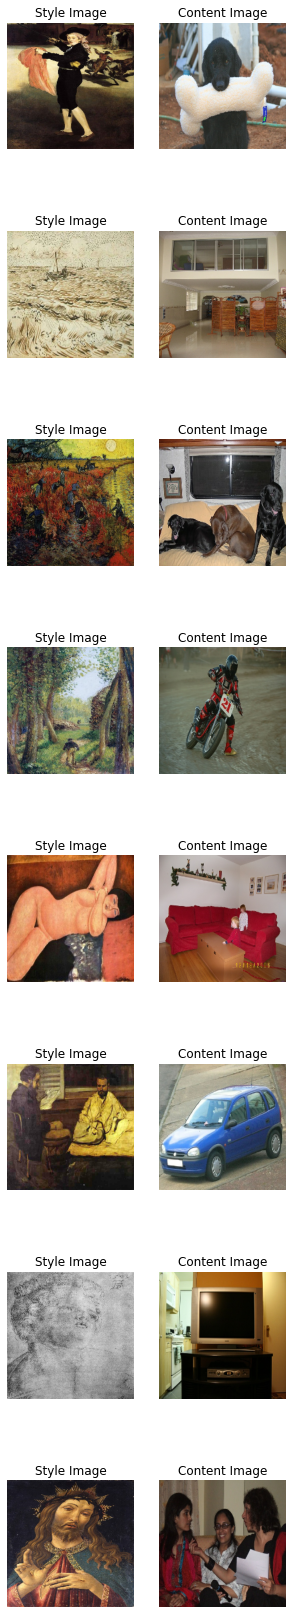

In [ ]:
style, content = next(iter(test_ds))
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(5, 30))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style[0:10], content[0:10]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

## Wikiart + CoCo

In [ ]:
# !wget -c http://msvocds.blob.core.windows.net/coco2014/train2014.zip
# !cp train2014.zip /content/drive/Shareddrives/Sam/Datasets/

In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/train2014.zip ./

In [ ]:
!cd /content/
!unzip train2014.zip
!rm -rf train2014.zip

In [ ]:
!cp /content/drive/Shareddrives/Sam/Datasets/wikiart.zip ./

In [ ]:
!cd /content/
!unzip wikiart.zip
!rm -rf wikiart.zip

In [2]:
STYLE_DIR = 'wikiart'

folders = [os.path.join(STYLE_DIR, folder) for folder in os.listdir(STYLE_DIR)]
styles = []
for folder in folders:
    styles += [os.path.join(folder, filename) for filename in os.listdir(folder)]
len(styles)

81446

In [3]:
CONTENT_DIR = 'train2014'

contents = [os.path.join(CONTENT_DIR, filename) for filename in os.listdir(CONTENT_DIR)]
len(contents)

82783

In [4]:
def resize_image(image):
    if not image.shape[0] == None:
        scale = MAX_DIM/max(image.shape)
        image = image.resize((round(image.size[0]*scale), 
                            round(image.size[1]*scale)), Image.ANTIALIAS)
    return image

In [5]:
def decode_and_resize(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = resize_image(image)
    image = tf.image.random_crop(image, size=(*CROP_SIZE, 3))
    image = tf.image.convert_image_dtype(image, dtype="float32")
    # image = tf.keras.applications.vgg19.preprocess_input(image)
    return image

In [6]:
# def resize(img, min_size=512):
#     """ Resize image and keep aspect ratio """
#     width, height, _ = tf.unstack(tf.shape(img), num=3)
#     if height < width:
#         new_height = min_size
#         new_width = int(width * new_height / height)
#     else:
#         new_width = min_size
#         new_height = int(height * new_width / width)
#     img = tf.image.resize(img, size=(new_width, new_height))
#     return img

# def resize_and_crop(img, min_size):
#     img = resize(img, min_size=min_size)
#     img = tf.image.random_crop(
#         img, size=(*IMAGE_SIZE, 3)
#     )
#     img = tf.cast(img, tf.float32)
#     return img

# def process_content(file_path):
#     img = tf.io.read_file(file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = resize_and_crop(img, min_size=286)
#     return img

# def process_style(file_path):
#     img = tf.io.read_file(file_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = resize_and_crop(img, min_size=512)
#     return img

In [7]:
BUFFER_SIZE = 64
BATCH_SIZE = 8

TRAIN, VAL, TEST = 0.8, 0.1, 0.1

train_style = styles[:int(TRAIN*len(styles))]
train_content = contents[:int(TRAIN*len(contents))]

val_style = styles[int(TRAIN*len(styles)):int((TRAIN+VAL)*len(styles))]
val_content = contents[int(TRAIN*len(contents)):int((TRAIN+VAL)*len(contents))]

test_style = styles[int((TRAIN+VAL)*len(styles)):]
test_content = contents[int((TRAIN+VAL)*len(contents)):]

In [8]:
train_style_ds = (
    tf.data.Dataset.from_tensor_slices(train_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_content_ds = (
    tf.data.Dataset.from_tensor_slices(train_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
val_style_ds = (
    tf.data.Dataset.from_tensor_slices(val_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_content_ds = (
    tf.data.Dataset.from_tensor_slices(val_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:
test_style_ds = (
    tf.data.Dataset.from_tensor_slices(test_style)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_content_ds = (
    tf.data.Dataset.from_tensor_slices(test_content)
    .map(decode_and_resize, num_parallel_calls=tf.data.AUTOTUNE)
    .apply(tf.data.experimental.ignore_errors())
    .shuffle(BUFFER_SIZE)
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
train_ds = (
    tf.data.Dataset.zip((train_style_ds, train_content_ds))
)

val_ds = (
    tf.data.Dataset.zip((val_style_ds, val_content_ds))
)

test_ds = (
    tf.data.Dataset.zip((test_style_ds, test_content_ds))
)

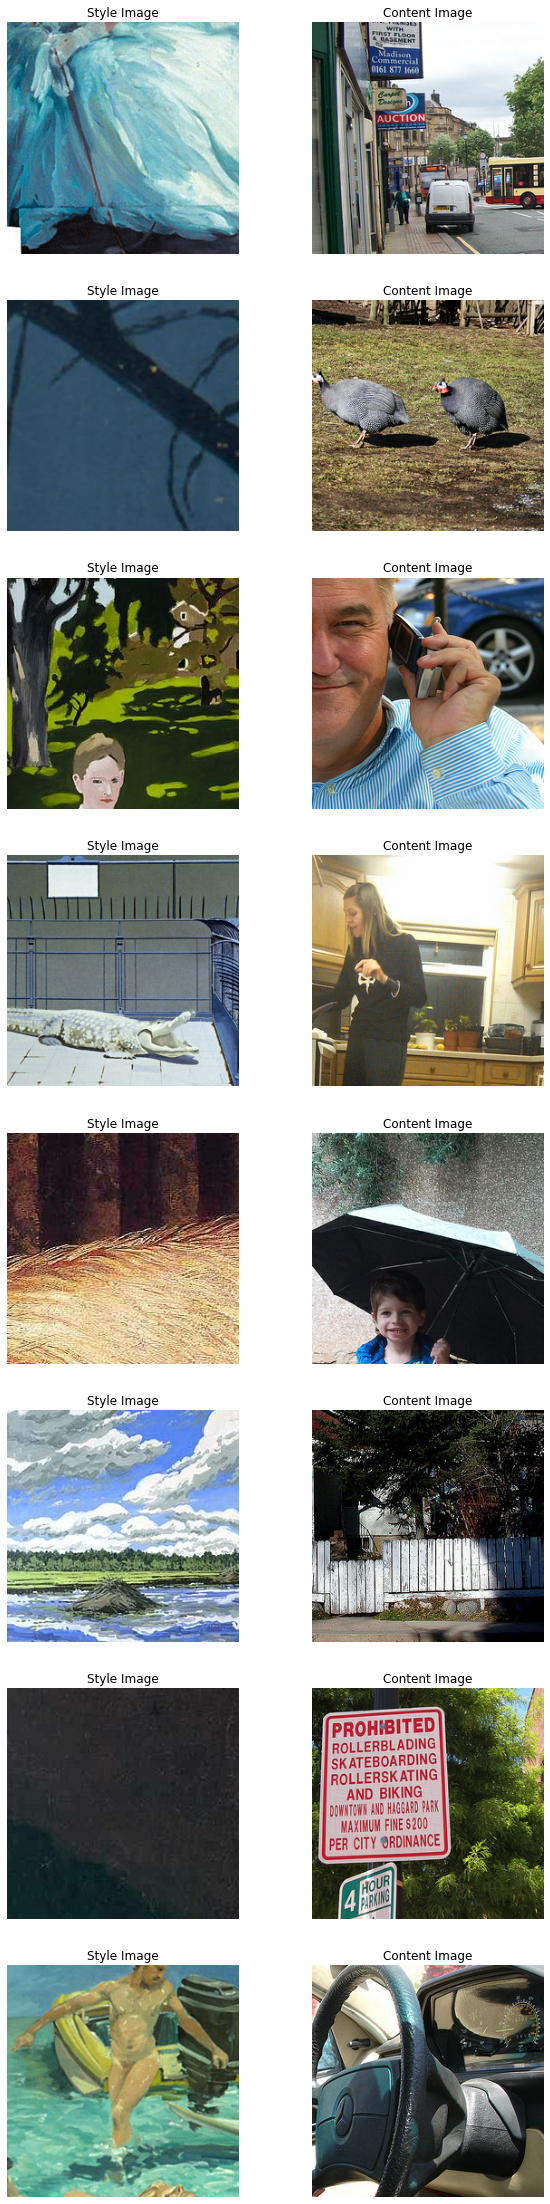

In [12]:
style_, content_ = next(iter(train_ds))

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 40))
[ax.axis("off") for ax in np.ravel(axes)]

for (axis, style_image, content_image) in zip(axes, style_[0:8], content_[0:8]):
    (ax_style, ax_content) = axis
    ax_style.imshow(style_image)
    ax_style.set_title("Style Image")

    ax_content.imshow(content_image)
    ax_content.set_title("Content Image")

# Networks

In [50]:
content_layers = ['block4_conv1'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1']

num_style_layers = len(style_layers)

In [51]:
def create_vgg_encoder():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]

    model_outputs = style_outputs + content_outputs

    return tf.keras.Model(vgg.input, model_outputs)

In [ ]:
class VGGEncoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

        style_outputs = [vgg.get_layer(name).output for name in style_layers]
        content_outputs = [vgg.get_layer(name).output for name in content_layers]

        model_outputs = style_outputs + content_outputs

        self.vgg = tf.keras.Model(vgg.input, model_outputs)
        self.vgg.trainable = False

    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs[:num_style_layers], outputs[num_style_layers:]

In [ ]:
class Decoder(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

        style_outputs = [vgg.get_layer(name).output for name in style_layers]
        content_outputs = [vgg.get_layer(name).output for name in content_layers]

        model_outputs = style_outputs + content_outputs

        self.vgg = tf.keras.Model(vgg.input, model_outputs)
        self.vgg.trainable = False

    def call(self, inputs):
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        return outputs[:num_style_layers], outputs[num_style_layers:]

In [52]:
def create_decoder():
    config = {"kernel_size": 3, "strides": 1, "padding": "same", "activation": "relu"}
    decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((None, None, 512)),
            tf.keras.layers.Conv2D(filters=512, **config),
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(filters=256, **config),
            tf.keras.layers.Conv2D(filters=256, **config),
            tf.keras.layers.Conv2D(filters=256, **config),
            tf.keras.layers.Conv2D(filters=256, **config),
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(filters=128, **config),
            tf.keras.layers.Conv2D(filters=128, **config),
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(filters=64, **config),
            tf.keras.layers.Conv2D(
                filters=3,
                kernel_size=3,
                strides=1,
                padding="same",
            ),
        ]
    )
    return decoder

In [53]:
# def get_decoder():
#     return keras.Sequential([
#         keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         keras.layers.UpSampling2D(),
#         keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
#         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#         keras.layers.UpSampling2D(),
#         keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
#         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#         keras.layers.UpSampling2D(),
#         keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#         keras.layers.Conv2D(3, (3, 3), padding='same', activation='relu'),
#     ])

In [54]:
# arch = [                                                        #  HxW  / InC->OutC
#     Conv2DReflect(256, 3, padding='valid', activation='relu'),  # 32x32 / 512->256
#     UpSampling2D(),                                             # 32x32 -> 64x64
#     Conv2DReflect(256, 3, padding='valid', activation='relu'),  # 64x64 / 256->256
#     Conv2DReflect(256, 3, padding='valid', activation='relu'),  # 64x64 / 256->256
#     Conv2DReflect(256, 3, padding='valid', activation='relu'),  # 64x64 / 256->256
#     Conv2DReflect(128, 3, padding='valid', activation='relu'),  # 64x64 / 256->128
#     UpSampling2D(),                                             # 64x64 -> 128x128
#     Conv2DReflect(128, 3, padding='valid', activation='relu'),  # 128x128 / 128->128
#     Conv2DReflect(64, 3, padding='valid', activation='relu'),   # 128x128 / 128->64
#     UpSampling2D(),                                             # 128x128 -> 256x256
#     Conv2DReflect(64, 3, padding='valid', activation='relu'),   # 256x256 / 64->64
#     Conv2DReflect(3, 3, padding='valid', activation=None)]      # 256x256 / 64->3

In [55]:
def get_mean_std(x, epsilon=1e-5):
    mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    std = tf.sqrt(var + epsilon)
    return mean, std


def AdaIN(styles_c, contents_c):
    contents_mean, contents_std = get_mean_std(contents_c)
    styles_mean, styles_std = get_mean_std(styles_c)

    t = styles_std * (contents_c - contents_mean) / contents_std + styles_mean
    return t

In [56]:
loss_fn = tf.keras.losses.MeanSquaredError()

In [57]:
def content_loss(contents, content_targets):
    return loss_fn(contents, content_targets)

In [58]:
def style_loss_fn(style, style_target):
    style_mean, style_std = get_mean_std(style)
    target_mean, target_std = get_mean_std(style_target)
    return loss_fn(style_mean, target_mean) + loss_fn(style_std, target_std)

In [59]:
def style_loss(styles, style_targets):
    return tf.reduce_sum([style_loss_fn(s, t) 
                            for s,t in zip(styles, style_targets)])

In [60]:
style_weight = 10.0
content_weight = 1.0

In [61]:
vgg_encoder = create_vgg_encoder()

decoder = create_decoder()

In [62]:
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
                   initial_learning_rate=1e-4, decay_steps=1.0, decay_rate=5e-5)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

In [63]:
train_total_loss = tf.keras.metrics.Mean(name="total_loss")
train_style_loss = tf.keras.metrics.Mean(name="style_loss")
train_content_loss = tf.keras.metrics.Mean(name="content_loss")

In [64]:
@tf.function
def train_step(styles, contents):
    outputs = vgg_encoder(contents)
    contents_s, contents_c  = (outputs[:num_style_layers],outputs[num_style_layers:])

    outputs = vgg_encoder(styles)
    styles_s, styles_c  = (outputs[:num_style_layers], outputs[num_style_layers:])

    ada_out = AdaIN(styles_c=styles_c[0], contents_c=contents_c[0])
    with tf.GradientTape() as tape:
        outputs = decoder(ada_out)

        outputs = vgg_encoder(outputs)
        reconsts_s, reconsts_c  = (outputs[:num_style_layers], outputs[num_style_layers:])

        c_loss = content_loss(reconsts_c[0], ada_out)
        s_loss = style_loss(reconsts_s, styles_s)

        loss = style_weight * s_loss + content_weight * c_loss

    grads = tape.gradient(loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads, decoder.trainable_variables))

    train_total_loss(loss)
    train_style_loss(s_loss)
    train_content_loss(c_loss)

In [65]:
def test_step():
    styles_test, contents_test = next(iter(test_ds))

    fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(10, 30))
    [ax.axis("off") for ax in np.ravel(axes)]

    outputs = vgg_encoder(contents_test)
    contents_s, contents_c  = (outputs[:num_style_layers],
                            outputs[num_style_layers:])
    outputs = vgg_encoder(styles_test)
    styles_s, styles_c  = (outputs[:num_style_layers],
                        outputs[num_style_layers:])

    ada_out = AdaIN(styles_c=styles_c[0], contents_c=contents_c[0])

    outputs = decoder(ada_out)
    outputs = tf.clip_by_value(outputs, clip_value_min=0.0, clip_value_max=1.0) * 255.
    outputs = tf.cast(outputs, tf.uint8)

    for (axis, style, content, reconst) in zip(axes, styles_test[0:8], contents_test[0:8], outputs[0:8]):
        (ax_style, ax_content, ax_reconst) = axis
        
        ax_style.imshow(style)
        ax_style.set_title("Style Image")

        ax_content.imshow(content)
        ax_content.set_title("Content Image")

        ax_reconst.imshow(reconst)
        ax_reconst.set_title("Reconstructed Image")
    plt.show()

999it [03:38,  4.58it/s]


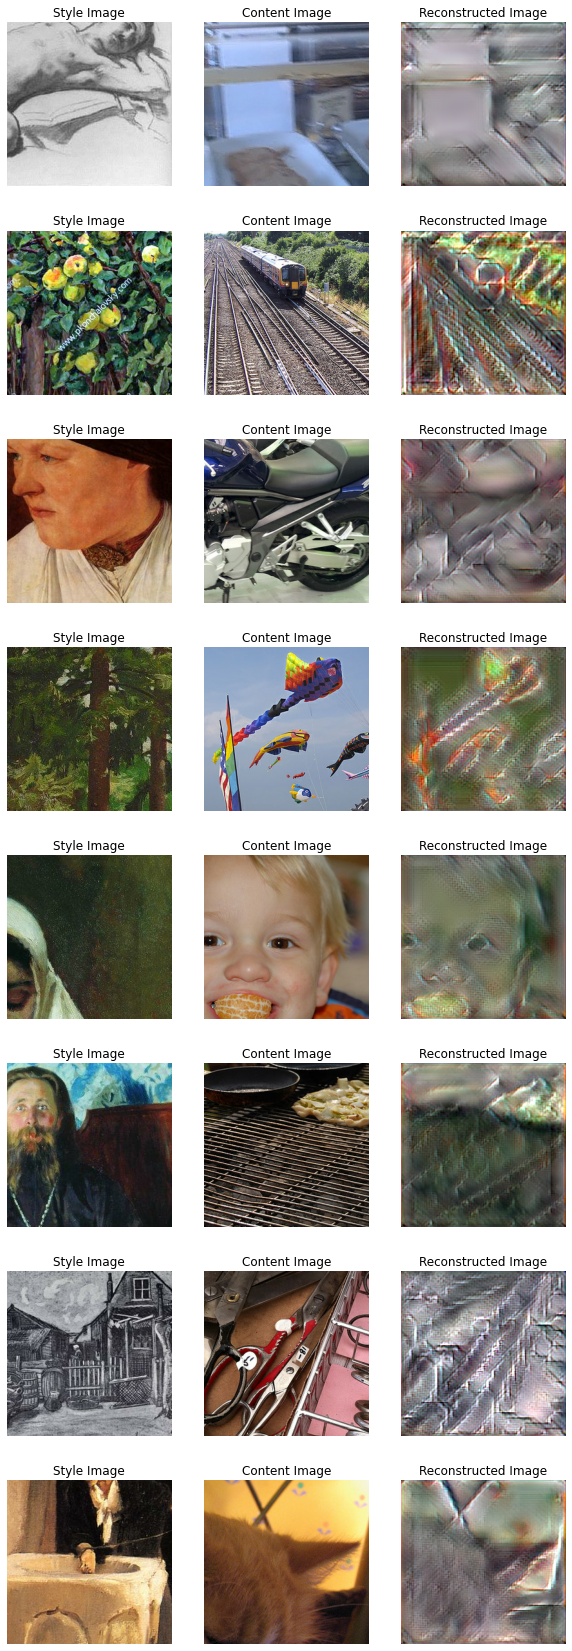

Step 1000, Loss: 294.1266784667969, Style Loss: 19.70050811767578, Content Loss: 97.12140655517578


430it [01:33,  4.63it/s]

In [ ]:
epochs = 100
steps_per_epoch = 1000

for i in range(epochs):
    s_loss, c_loss, loss = 0.0, 0.0, 0.0
    step = 0
    for styles, contents in tqdm(train_ds):
        step += 1
        train_step(styles, contents)

        if step >= steps_per_epoch:
            break

    test_step()
    print(
        f"Step {step}, "
        f"Loss: {train_total_loss.result()}, "
        f"Style Loss: {train_style_loss.result()}, "
        f"Content Loss: {train_content_loss.result()}"
    )

In [ ]:
decoder.save('decoder.h5')

In [ ]:
!cp decoder.h5 /content/drive/Shareddrives/Sam/GAN/